### **Intro Machine Learning - Home Assignment 6 - MNIST on Nueral Nerwork**

In [62]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [74]:
# Plot losses for under over fit
def plot_learning_curves(lossTrain, lossTest, epochs):
    plt.plot(epochs, lossTrain, label='Loss Train') # plot train line
    plt.plot(epochs, lossTest, label='Loss Test') # plot test line
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.grid(True)
    plt.legend()
    plt.show()

In [38]:
# Sample visualization
def visualize_predictions(images, true_labels, predicted_labels, num_samples=10,figsize=(20, 6)):
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    for i in range(num_samples):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        axes[i].axis('off')
    plt.show()

In [4]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred) # Create Confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # make the range of values between 0-1
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='magma', fmt='.3f', xticklabels=classes, yticklabels=classes) # Create hetmap
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [60]:
# Neural Network Implement 3 Layers
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize Network Architecture
        self._input_size = input_size
        self._hidden_size = hidden_size # get tuple of sizes (hidden-layer1,hidden-layer2,hidden-layer3)
        self._output_size = output_size
        
        # Initialize weights and biases with Xavier initialization (multiply with np.sqrt(2/(sum matrix sizes))
        self._weights1 = np.random.randn(self._input_size, self._hidden_size[0]) * np.sqrt(2 / (self._input_size + self._hidden_size[0]))
        self._bias1 = np.zeros((1, self._hidden_size[0]))
        self._weights2 = np.random.randn(self._hidden_size[0], self._hidden_size[1]) * np.sqrt(2 / (self._hidden_size[0] + self._hidden_size[1]))
        self._bias2 = np.zeros((1, self._hidden_size[1]))
        self._weights3 = np.random.randn(self._hidden_size[1], self._hidden_size[2]) * np.sqrt(2 / (self._hidden_size[1] + self._hidden_size[2]))
        self._bias3 = np.zeros((1, self._hidden_size[2]))
        self._weights4 = np.random.randn(self._hidden_size[2], self._output_size) * np.sqrt(2 / (self._hidden_size[2] + self._output_size))
        self._bias4 = np.zeros((1, self._output_size))
    
    def forward(self, X):
        # Feed Forward propagation
        
        # Layer #1 - ReLU
        self.z1 = np.dot(X, self._weights1) + self._bias1
        self.a1 = self.__relu(self.z1)
        
        # Layer #2 - ReLU
        self.z2 = np.dot(self.a1, self._weights2) + self._bias2
        self.a2 = self.__relu(self.z2)

        # Layer #3 - ReLU
        self.z3 = np.dot(self.a2, self._weights3) + self._bias3
        self.a3 = self.__relu(self.z3)
        
        # Layer #2 - Softmax
        self.z4 = np.dot(self.a3, self._weights4) + self._bias4
        self.a4 = self.__softmax(self.z4)
        return self.a4 # Output of layer #2
        
    def backward(self, X, y, learning_rate, regularization=0.01):
        # Backward propagation with regularization
        m = X.shape[0]
        
        # Layer #4 backward
        self.dz4 = self.a4 - y # Cross-Entropy
        self.dw4 = np.dot(self.a3.T, self.dz4) / m + (regularization * self._weights4) / m
        self.db4 = np.sum(self.dz4, axis=0, keepdims=True) / m
        # Layer #3 backward
        self.dz3 = np.dot(self.dz4, self._weights4.T) * self.__relu_derivative(self.z3)
        self.dw3 = np.dot(self.a2.T, self.dz3) / m + (regularization * self._weights3) / m
        self.db3 = np.sum(self.dz3, axis=0, keepdims=True) / m
        # Layer #2 backward
        self.dz2 = np.dot(self.dz3, self._weights3.T) * self.__relu_derivative(self.z2)
        self.dw2 = np.dot(self.a1.T, self.dz2) / m + (regularization * self._weights2) / m
        self.db2 = np.sum(self.dz2, axis=0, keepdims=True) / m
        # Layer #1 backward
        self.dz1 = np.dot(self.dz2, self._weights2.T) * self.__relu_derivative(self.z1)
        self.dw1 = np.dot(X.T, self.dz1) / m + (regularization * self._weights1) / m
        self.db1 = np.sum(self.dz1, axis=0, keepdims=True) / m
        
        # Update weights and biases
        self._weights1 -= learning_rate * self.dw1
        self._bias1 -= learning_rate * self.db1
        self._weights2 -= learning_rate * self.dw2
        self._bias2 -= learning_rate * self.db2
        self._weights3 -= learning_rate * self.dw3
        self._bias3 -= learning_rate * self.db3
        self._weights4 -= learning_rate * self.dw4
        self._bias4 -= learning_rate * self.db4
    
    def fit(self, X, y, X_test, y_test, num_epochs, batch_size, initial_learning_rate, decay_rate, step_size, regularization=0.01,verbose=False):
        m = X.shape[0]
        lossVals = [] # Loss values records for graph
        if verbose is True:
            self._verbose = True
        else:
            self._verbose = False
        
        # Convert the labels to one-hot encoding
        y = np.eye(self._output_size)[y]
        y_test = np.eye(self._output_size)[y_test]  # This for comparing the loss for check overfit on graph
        
        for epoch in range(num_epochs):
            # Shuffle the training data for batch
            permutation = np.random.permutation(m) # Shuffle index between 0-m 
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            
            # Update the learning rate
            learning_rate = self.__step_decay(epoch, initial_learning_rate, decay_rate, step_size)
            
            for i in range(0, m, batch_size):
                # Create batch for training
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Forward and Backward Propagation
                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, learning_rate, regularization)
                
            lossTrain = self.__cross_entropy_loss(y, self.forward(X))
            lossTest = self.__cross_entropy_loss(y_test, self.forward(X_test))
            lossVals.append((lossTrain,lossTest))
            if self._verbose is True: # print lose if verbose is True
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {lossTrain}, learning_rate: {learning_rate}")
        
        return lossVals
        
    def predict(self, X):
        # Take the highest value in softmax result for each sample to be the labels prediction
        predicted_classes = np.argmax(self.forward(X), axis=1) 
        return predicted_classes
    
    def score(self, y_true, y_pred):
        F1 = f1_score(y_true, y_pred, average='macro')
        Accuracy = (y_true == y_pred).mean()
        return Accuracy, F1
    
    def __step_decay(self, epoch, initial_lr, decay_rate, step_size):
        # Function for update learning rate
        return initial_lr * decay_rate ** (epoch // step_size)
        
    def __relu(self, x):
        # ReLU Activation function
        return np.maximum(0, x)
    
    def __relu_derivative(self, x):
        # ReLU derivative function
        return np.where(x <= 0, 0, 1)
    
    def __softmax(self, x):
        # Softmax Activation function
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def __cross_entropy_loss(self, y_true, y_pred):
        # Cross entropy Loss Function
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred)) # using mean for work with smaller numbers


Loading MNIST From SKLEARN by fetch

In [63]:
# Load the MNIST dataset from SKLEARN by fetch the dataset
mnist = fetch_openml('mnist_784') # take while till finish fetch and load dataset

# Extract the data and labels
X = mnist.data
y = mnist.target

# Convert the data to float and normalize
X = X.astype('float32')
X /= 255.0 # Normalize

# Convert labels to integers
y = y.astype('int')

Loading MNIST From npy file

In [70]:
# Load MNIST from npy file
X = np.load('MNIST-data.npy')
y = np.load("MNIST-lables.npy")

# Convert the data to float and normalize
X = X.astype('float32')
X /= 255.0 # Normalize

# Convert labels to integers
y = y.astype('int')

In [71]:
# Prepering the dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True,random_state=None)
num_classes = 10
# Reshape the input data to match the to the expected shape of the neural network
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In [72]:
# Set the hyperparameters for training
# Architecture Hyperparameter
input_size = 784
hidden_size = (512, 128,64)
output_size = num_classes # 10 in MNIST

# Learning Hyperparameter
learning_rate = 0.1
num_epochs = 15
batch_size = 16
regularization = 0.01
decay_rate = 0.5
step_size = 3

Run 10 times the network for check the mean and mediran score

In [24]:
# This cell runtime is around one hour
res = []
for _ in range(10):
    nn = NeuralNetwork(input_size, hidden_size, output_size)
    # Fitting the network with train set (test set sent only for see loss on graph)
    losses = nn.fit( X_train, y_train, X_test, y_test,
                    num_epochs=num_epochs,
                    batch_size=batch_size,
                    initial_learning_rate=learning_rate,
                    decay_rate=decay_rate, 
                    step_size=step_size,
                    regularization=regularization,
                    verbose=True)
    y_pred = nn.predict(X_test) # Predict the test set
    Accuracy, F1 = nn.score(y_test, y_pred) # Get the score of the network
    res.append(Accuracy)
    print(f'Network Architecture: input_size={input_size}, hidden_size={hidden_size}, output_size={output_size}')
    print(f'Hyper Parameters: learning_rate={learning_rate}, num_epochs={num_epochs}, batch_size={batch_size}')
    print(f'Hyper Parameters: regularization={regularization}, decay_rate={decay_rate}, step_size={step_size}')
    print(f'Accuracy Score = {Accuracy:.04f}, F1 Score = {F1:.04f}')
    print("--------------------------------------------------------------------------")

Epoch 1/15, Loss: 0.010776440322775681, learning_rate: 0.1
Epoch 2/15, Loss: 0.007092309317123372, learning_rate: 0.1
Epoch 3/15, Loss: 0.005439176686612637, learning_rate: 0.1
Epoch 4/15, Loss: 0.0029394281943564914, learning_rate: 0.05
Epoch 5/15, Loss: 0.00241723255749433, learning_rate: 0.05
Epoch 6/15, Loss: 0.0020751377426859244, learning_rate: 0.05
Epoch 7/15, Loss: 0.001481203004439925, learning_rate: 0.025
Epoch 8/15, Loss: 0.0013392563456081357, learning_rate: 0.025
Epoch 9/15, Loss: 0.0014617959916229883, learning_rate: 0.025
Epoch 10/15, Loss: 0.001067654584991599, learning_rate: 0.0125
Epoch 11/15, Loss: 0.0010206080153936465, learning_rate: 0.0125
Epoch 12/15, Loss: 0.0010164596450007322, learning_rate: 0.0125
Epoch 13/15, Loss: 0.0009855920702900776, learning_rate: 0.00625
Epoch 14/15, Loss: 0.000986749081086306, learning_rate: 0.00625
Epoch 15/15, Loss: 0.000960321188081071, learning_rate: 0.00625
Network Architecture: input_size=784, hidden_size=(512, 128, 64), output_

Print the summary of the 10 runs


In [29]:
# Print the summary of the 10 runs
res2 = np.array(res)
print("--------------------------------------------------------------------------")
print(f'Network Architecture: input_size={input_size}, hidden_size={hidden_size}, output_size={output_size}')
print(f'Hyper Parameters: learning_rate={learning_rate}, num_epochs={num_epochs}, batch_size={batch_size}')
print(f'Hyper Parameters: regularization={regularization}, decay_rate={decay_rate}, step_size={step_size}')
print(f'Network results on 10 runs: mean = {res2.mean():.04f}, median = {np.median(res2):.04f}')
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Network Architecture: input_size=784, hidden_size=(512, 128, 64), output_size=10
Hyper Parameters: learning_rate=0.1, num_epochs=15, batch_size=16
Hyper Parameters: regularization=0.01, decay_rate=0.5, step_size=3
Network results on 10 runs: mean = 0.9830, median = 0.9831
--------------------------------------------------------------------------


### **Classic run of the NeuralNetwork**

In [23]:
# Create the NeuralNetwork class
nn = NeuralNetwork(input_size, hidden_size, output_size)
# Fitting the network with train set (test set sent only for see loss on graph)
losses = nn.fit( X_train, y_train, X_test, y_test,
                num_epochs=num_epochs,
                batch_size=batch_size,
                initial_learning_rate=learning_rate,
                decay_rate=decay_rate, 
                step_size=step_size,
                regularization=regularization,
                verbose=True)
y_pred = nn.predict(X_test) # Predict the test set
Accuracy, F1 = nn.score(y_test, y_pred) # Get the score of the network
print(f'Network Architecture: input_size={input_size}, hidden_size={hidden_size}, output_size={output_size}')
print(f'Hyper Parameters: learning_rate={learning_rate}, num_epochs={num_epochs}, batch_size={batch_size}')
print(f'Hyper Parameters: regularization={regularization}, decay_rate={decay_rate}, step_size={step_size}')
print(f'Accuracy Score = {Accuracy:.04f}, F1 Score = {F1:.04f}')
print("--------------------------------------------------------------------------")


Epoch 1/15, Loss: 0.009611193835315059, learning_rate: 0.1
Epoch 2/15, Loss: 0.0064352628316676755, learning_rate: 0.1
Epoch 3/15, Loss: 0.004889380822131926, learning_rate: 0.1
Epoch 4/15, Loss: 0.0030669342601175368, learning_rate: 0.05
Epoch 5/15, Loss: 0.0027088788106608428, learning_rate: 0.05
Epoch 6/15, Loss: 0.0030130333412194802, learning_rate: 0.05
Epoch 7/15, Loss: 0.0013886397644251602, learning_rate: 0.025
Epoch 8/15, Loss: 0.0014214393739913048, learning_rate: 0.025
Epoch 9/15, Loss: 0.0012804593168228035, learning_rate: 0.025
Epoch 10/15, Loss: 0.001091165001063928, learning_rate: 0.0125
Epoch 11/15, Loss: 0.0010724817230839932, learning_rate: 0.0125
Epoch 12/15, Loss: 0.0010260826666459786, learning_rate: 0.0125
Epoch 13/15, Loss: 0.001002826809119719, learning_rate: 0.00625
Epoch 14/15, Loss: 0.0009873725216417366, learning_rate: 0.00625
Epoch 15/15, Loss: 0.0010004098691470187, learning_rate: 0.00625
Network Architecture: input_size=784, hidden_size=(512, 128, 64), ou

### **Results Visualization**

Sample of images and corresponding labels

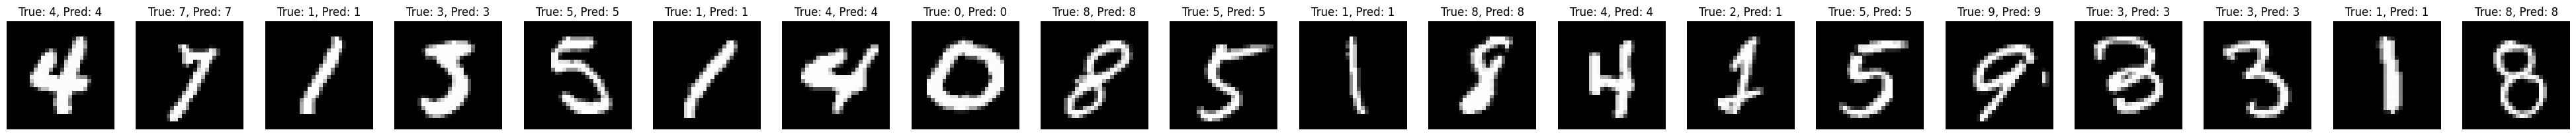

In [55]:
# Sample of images and corresponding labels
samples = 20 # number of samples in plot
permutation = np.random.permutation(len(X_test)) # random the samples
sample_images = X_test[permutation]
true_labels = y_test[permutation]
pred_labels = y_pred[permutation]
# Visualize the predictions of sample
visualize_predictions(sample_images[:samples], true_labels[:samples], pred_labels[:samples],num_samples=samples,figsize=(50,20))

Samples of images that the network predicted with wrong label 


Number of false predictions 227


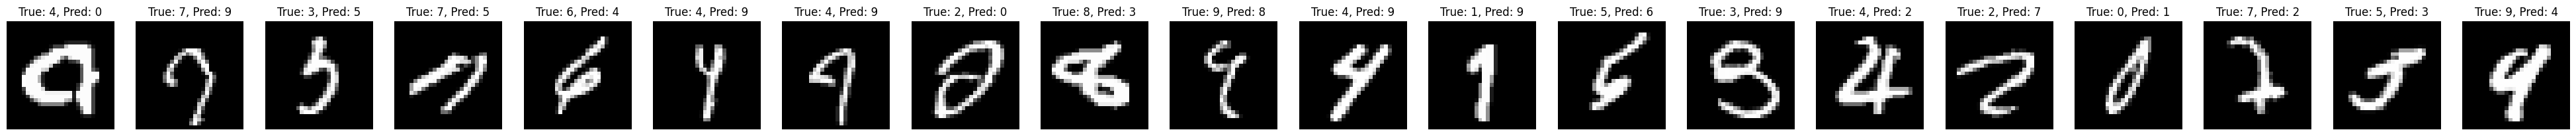

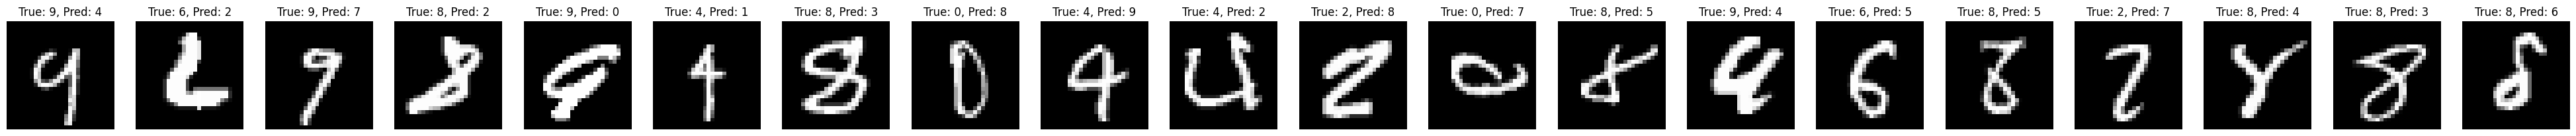

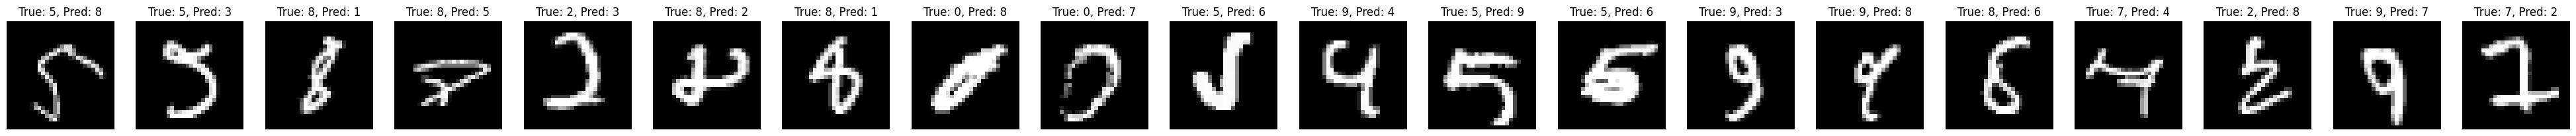

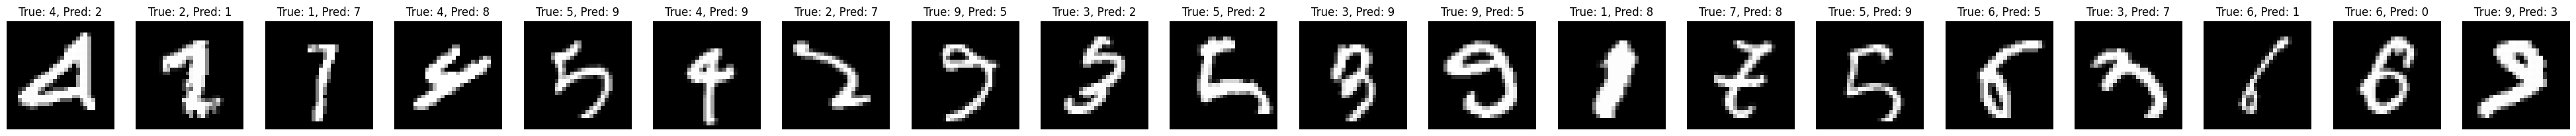

In [75]:
# Samples with wrong predictions 
# pick only wrong predictions
wrong_predict_idx = np.where(y_test != y_pred)[0]
print(f'Number of false predictions {len(wrong_predict_idx)}')
sample_images_w = X_test[wrong_predict_idx]
true_labels_w = y_test[wrong_predict_idx]
pred_labels_w = y_pred[wrong_predict_idx]
# Take sample
samples = 20 # number of samples in plot
# Show 80 samples with wrong predictions
visualize_predictions(sample_images_w[0:20], true_labels_w[0:20], pred_labels_w[0:20],num_samples=samples,figsize=(50,20))
visualize_predictions(sample_images_w[20:40], true_labels_w[20:40], pred_labels_w[20:40],num_samples=samples,figsize=(50,20))
visualize_predictions(sample_images_w[40:60], true_labels_w[40:60], pred_labels_w[40:60],num_samples=samples,figsize=(50,20))
visualize_predictions(sample_images_w[60:80], true_labels_w[60:80], pred_labels_w[60:80],num_samples=samples,figsize=(50,20))


**Plot the confusion matrix**

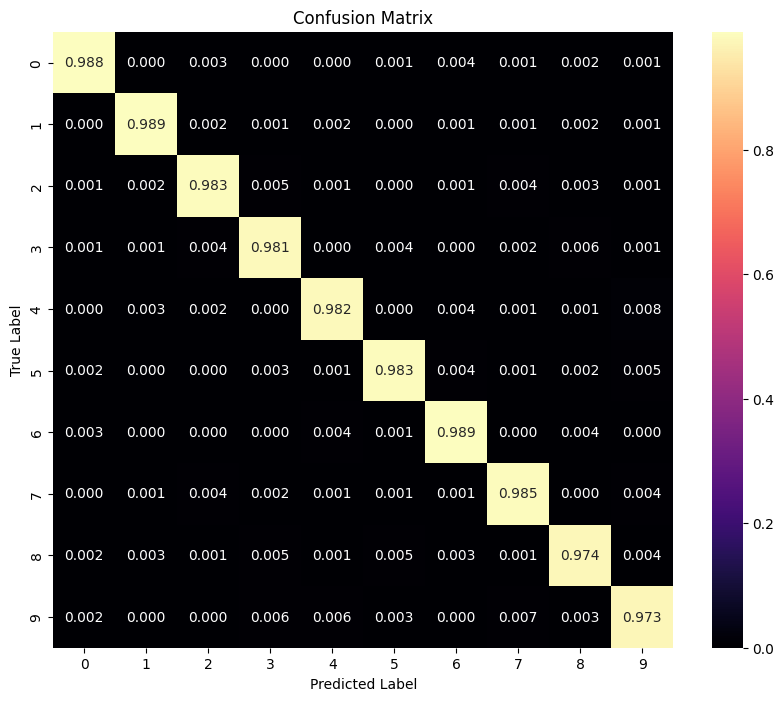

In [30]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=[str(i) for i in range(num_classes)])

**Loss Comparison Graph plot**

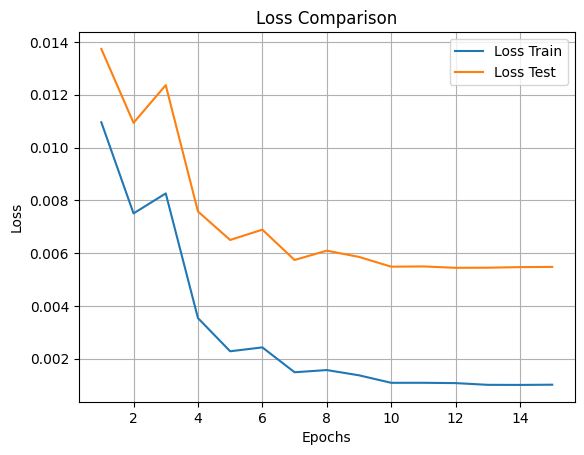

In [31]:
# Loss Comparison Graph plot
epochs = [i+1 for i in range(num_epochs)]
trn_losses = []
tst_losses = []
for train_loss, test_loss in losses:
    trn_losses.append(train_loss)
    tst_losses.append(test_loss)
plot_learning_curves(trn_losses, tst_losses, epochs)